In [2]:
# ==========================================================
# Telco Churn Project — Clean, Fresh, Version-Agnostic Code
# ==========================================================
# Works on older scikit-learn (no 'sparse_output', no 'squared' kwarg)
# ----------------------------------------------------------

# !pip install pandas numpy scikit-learn matplotlib imbalanced-learn xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans

In [4]:
# ----------------------------------------------------------
# 0) Repro + Config
# ----------------------------------------------------------
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams["figure.figsize"] = (6,4)

In [5]:
# ----------------------------------------------------------
# 1) Load + Basic Cleaning
# ----------------------------------------------------------
csv_path = Path("Telco-Customer-Churn.csv")  # ensure file is here
df = pd.read_csv(csv_path)


In [6]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [7]:
# normalize column names
df.columns = df.columns.str.strip().str.replace(" ", "_")

In [8]:
# Fix TotalCharges (has blanks)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
mask_tc_na = df["TotalCharges"].isna()
if mask_tc_na.any():
    df.loc[mask_tc_na, "TotalCharges"] = df.loc[mask_tc_na, "MonthlyCharges"] * df.loc[mask_tc_na, "tenure"]

In [9]:
# Binary target
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1}).astype(int)

In [10]:
# ----------------------------------------------------------
# 2) Feature Engineering (Age/Region synthetic) + CLV
# ----------------------------------------------------------
rng = np.random.default_rng(RANDOM_STATE)

def synth_age(sr):
    return int(rng.integers(60, 91)) if sr == 1 else int(rng.integers(18, 60))

df["Age"] = df["SeniorCitizen"].apply(synth_age)

regions = np.array(["North","South","East","West"])
df["Region"] = df["customerID"].apply(lambda x: regions[hash(x) % 4])

# CLV as requested
df["CLV"] = df["MonthlyCharges"] * df["tenure"]

In [11]:
df["CLV"]

0         29.85
1       1936.30
2        107.70
3       1903.50
4        141.40
         ...   
7038    2035.20
7039    7430.40
7040     325.60
7041     297.60
7042    6972.90
Name: CLV, Length: 7043, dtype: float64

In [12]:
# ----------------------------------------------------------
# 3) EDA (lightweight prints & a few plots)
# ----------------------------------------------------------
print("Shape:", df.shape)
print("\nMissing values:\n", df.isna().sum())
print("\nChurn rate:", df["Churn"].mean().round(4))

Shape: (7043, 24)

Missing values:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
Age                 0
Region              0
CLV                 0
dtype: int64

Churn rate: 0.2654


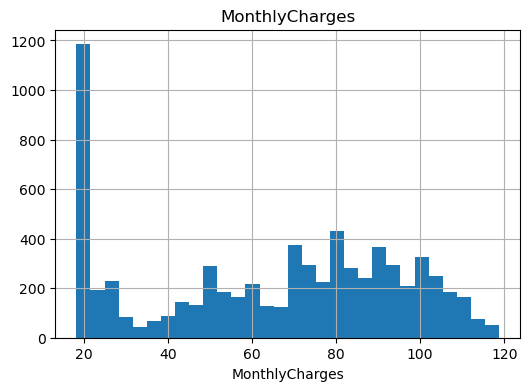

In [13]:
# Histograms
df["MonthlyCharges"].hist(bins=30)
plt.title("MonthlyCharges")
plt.xlabel("MonthlyCharges")
plt.show()

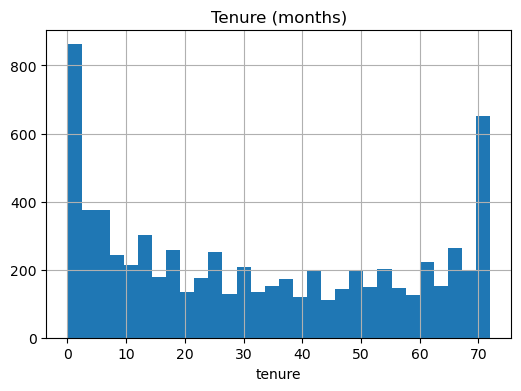

In [14]:
df["tenure"].hist(bins=30)
plt.title("Tenure (months)")
plt.xlabel("tenure")
plt.show()

In [15]:
print("\nChurn by Contract:\n", df.groupby("Contract")["Churn"].mean().sort_values())
print("\nChurn by Region:\n", df.groupby("Region")["Churn"].mean().sort_values())


Churn by Contract:
 Contract
Two year          0.028319
One year          0.112695
Month-to-month    0.427097
Name: Churn, dtype: float64

Churn by Region:
 Region
North    0.258797
South    0.262609
West     0.262707
East     0.277008
Name: Churn, dtype: float64


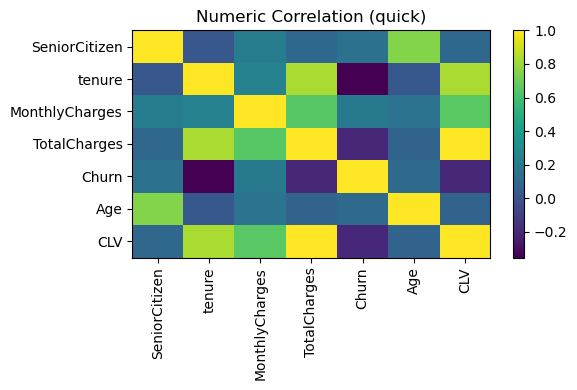

In [16]:
# Numeric correlation quick look
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols].corr()
plt.imshow(corr, aspect="auto")
plt.title("Numeric Correlation (quick)")
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.tight_layout()
plt.show()

In [19]:
# ----------------------------------------------------------
# 4) Modeling Features
# ----------------------------------------------------------
base_features = [
    "gender","SeniorCitizen","Partner","Dependents","tenure",
    "PhoneService","MultipleLines","InternetService","OnlineSecurity","OnlineBackup",
    "DeviceProtection","TechSupport","StreamingTV","StreamingMovies",
    "Contract","PaperlessBilling","PaymentMethod","MonthlyCharges","TotalCharges",
    "Age","Region"
]

X = df[base_features].copy()
y = df["Churn"].copy()

numeric_features = ["tenure","MonthlyCharges","TotalCharges","Age"]
categorical_features = list(set(base_features) - set(numeric_features))

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        # Updated to use sparse_output instead of sparse for newer sklearn versions
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ]
)

In [20]:
# ----------------------------------------------------------
# 5) Train/Test Split
# ----------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

In [21]:
# ----------------------------------------------------------
# 6) Build Models (Classification)
# ----------------------------------------------------------
models = {}

lr = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="liblinear"))
])
models["LogisticRegression"] = lr

rf = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1))
])
models["RandomForest"] = rf

# Optional XGBoost (if installed)
try:
    from xgboost import XGBClassifier
    xgb = Pipeline([
        ("prep", preprocess),
        ("clf", XGBClassifier(
            n_estimators=500, max_depth=5, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.9,
            random_state=RANDOM_STATE, eval_metric="logloss", n_jobs=-1
        ))
    ])
    models["XGBoost"] = xgb
except Exception as e:
    print("XGBoost not available, skipping:", e)

In [22]:
# ----------------------------------------------------------
# 7) Fit + Evaluate (Classification)
# ----------------------------------------------------------
def evaluate_classifier(name, pipe, X_tr, y_tr, X_te, y_te, threshold=0.5, show_report=True):
    pipe.fit(X_tr, y_tr)
    proba = pipe.predict_proba(X_te)[:, 1]
    preds = (proba >= threshold).astype(int)

    acc = accuracy_score(y_te, preds)
    prec = precision_score(y_te, preds, zero_division=0)
    rec = recall_score(y_te, preds, zero_division=0)
    f1 = f1_score(y_te, preds, zero_division=0)
    auc = roc_auc_score(y_te, proba)

    print(f"\n=== {name} @ threshold={threshold:.2f} ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {auc:.4f}")
    print("\nConfusion matrix:\n", confusion_matrix(y_te, preds))
    if show_report:
        print("\nClassification report:\n", classification_report(y_te, preds, zero_division=0))

    return {"model": pipe, "proba": proba, "threshold": threshold,
            "metrics": {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc}}

results = {}
for name, pipe in models.items():
    results[name] = evaluate_classifier(name, pipe, X_train, y_train, X_test, y_test)


=== LogisticRegression @ threshold=0.50 ===
Accuracy:  0.7479
Precision: 0.5159
Recall:    0.8009
F1-score:  0.6275
ROC-AUC:   0.8450

Confusion matrix:
 [[943 351]
 [ 93 374]]

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.73      0.81      1294
           1       0.52      0.80      0.63       467

    accuracy                           0.75      1761
   macro avg       0.71      0.76      0.72      1761
weighted avg       0.81      0.75      0.76      1761


=== RandomForest @ threshold=0.50 ===
Accuracy:  0.7836
Precision: 0.6162
Recall:    0.4882
F1-score:  0.5448
ROC-AUC:   0.8339

Confusion matrix:
 [[1152  142]
 [ 239  228]]

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1294
           1       0.62      0.49      0.54       467

    accuracy                           0.78      1761
   macro avg       0.72      0.69      0.70      17

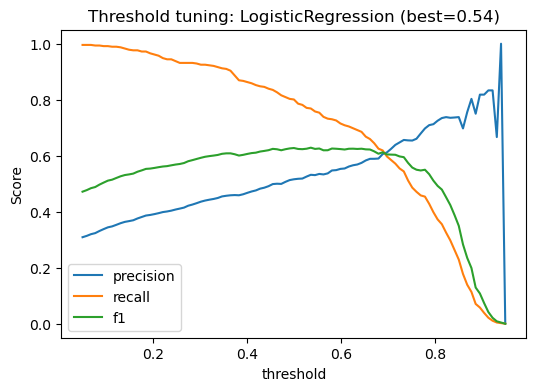

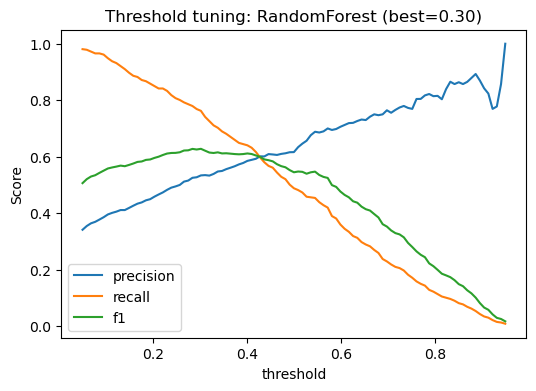

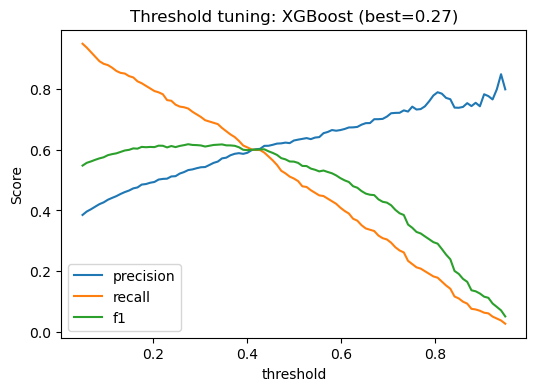

In [23]:
# ----------------------------------------------------------
# 8) Threshold Tuning (balance FP/FN)
# ----------------------------------------------------------
def sweep_thresholds(y_true, proba, steps=101):
    ts = np.linspace(0.05, 0.95, steps)
    rows = []
    for t in ts:
        pred = (proba >= t).astype(int)
        rows.append({
            "threshold": t,
            "precision": precision_score(y_true, pred, zero_division=0),
            "recall": recall_score(y_true, pred, zero_division=0),
            "f1": f1_score(y_true, pred, zero_division=0)
        })
    return pd.DataFrame(rows)

best_thresholds = {}
for name, r in results.items():
    df_thr = sweep_thresholds(y_test, r["proba"])
    t_star = df_thr.loc[df_thr["f1"].idxmax(), "threshold"]
    best_thresholds[name] = (t_star, df_thr)

    ax = df_thr.plot(x="threshold", y=["precision","recall","f1"])
    ax.set_title(f"Threshold tuning: {name} (best={t_star:.2f})")
    ax.set_ylabel("Score")
    plt.show()

In [25]:
# Re-evaluate with each best threshold
for name, (t_star, _) in best_thresholds.items():
    evaluate_classifier(name + " (tuned)", results[name]["model"], X_train, y_train, X_test, y_test, threshold=t_star, show_report=False)


=== LogisticRegression (tuned) @ threshold=0.54 ===
Accuracy:  0.7592
Precision: 0.5319
Recall:    0.7687
F1-score:  0.6287
ROC-AUC:   0.8450

Confusion matrix:
 [[978 316]
 [108 359]]

=== RandomForest (tuned) @ threshold=0.30 ===
Accuracy:  0.7604
Precision: 0.5337
Recall:    0.7623
F1-score:  0.6279
ROC-AUC:   0.8339

Confusion matrix:
 [[983 311]
 [111 356]]

=== XGBoost (tuned) @ threshold=0.27 ===
Accuracy:  0.7592
Precision: 0.5333
Recall:    0.7366
F1-score:  0.6187
ROC-AUC:   0.8297

Confusion matrix:
 [[993 301]
 [123 344]]


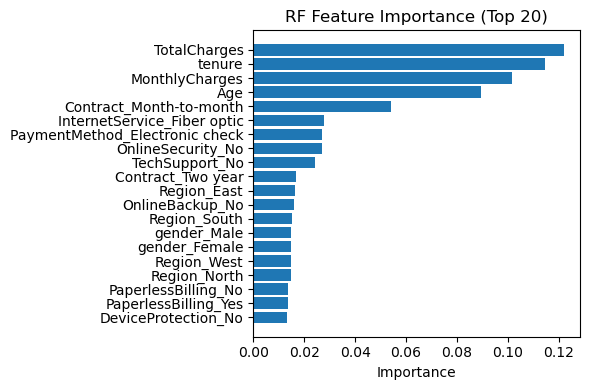

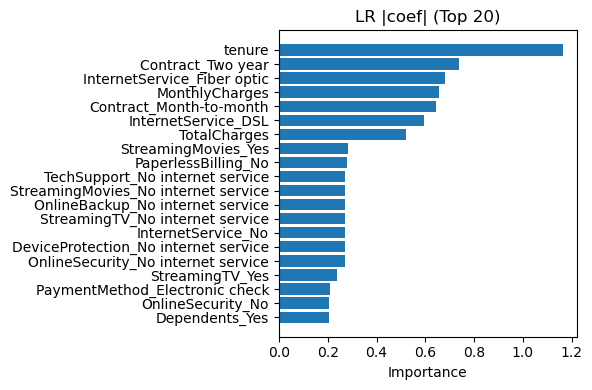

In [29]:
# ----------------------------------------------------------
# 9) Feature Importance (RF, LR)
# ----------------------------------------------------------
def get_feature_names(prep, num_cols, cat_cols):
    num_names = np.array(num_cols)  # StandardScaler has no get_feature_names_out in older versions
    # OneHotEncoder in older sklearn:
    cat_encoder = prep.named_transformers_["cat"]
    try:
        cat_names = cat_encoder.get_feature_names(cat_cols)
    except Exception:
        # newer API
        cat_names = cat_encoder.get_feature_names_out(cat_cols)
    return np.concatenate([num_names, cat_names])

def plot_top_importances(model_pipeline, X_sample, title="Feature Importance", topn=20):
    prep = model_pipeline.named_steps["prep"]
    clf = model_pipeline.named_steps[list(model_pipeline.named_steps.keys())[-1]]

    feature_names = get_feature_names(prep, numeric_features, categorical_features)

    if hasattr(clf, "feature_importances_"):
        imp = clf.feature_importances_
    elif hasattr(clf, "coef_"):
        imp = np.abs(clf.coef_.ravel())
    else:
        print("No feature importances available for this model.")
        return

    imp_df = pd.DataFrame({"feature": feature_names, "importance": imp}).sort_values("importance", ascending=False).head(topn)
    plt.barh(imp_df["feature"][::-1], imp_df["importance"][::-1])
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

if "RandomForest" in results:
    plot_top_importances(results["RandomForest"]["model"], X_test, title="RF Feature Importance (Top 20)")

if "LogisticRegression" in results:
    plot_top_importances(results["LogisticRegression"]["model"], X_test, title="LR |coef| (Top 20)")

In [26]:
# ----------------------------------------------------------
# 10) Regression (CLV) — version-agnostic RMSE
# ----------------------------------------------------------
y_reg = df.loc[X.index, "CLV"]

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_reg, test_size=0.25, random_state=RANDOM_STATE
)

reg_preprocess = preprocess

lin_reg = Pipeline([
    ("prep", reg_preprocess),
    ("reg", LinearRegression())
]).fit(X_train_r, y_train_r)
pred_lr = lin_reg.predict(X_test_r)

rf_reg = Pipeline([
    ("prep", reg_preprocess),
    ("reg", RandomForestRegressor(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1))
]).fit(X_train_r, y_train_r)
pred_rf = rf_reg.predict(X_test_r)

def eval_reg(y_true, y_pred, name):
    mse  = mean_squared_error(y_true, y_pred)   # plain MSE (version-agnostic)
    rmse = np.sqrt(mse)                         # RMSE manually
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"\n=== {name} (Regression) ===")
    print(f"RMSE: {rmse:.2f} | MAE: {mae:.2f} | R^2: {r2:.4f}")

eval_reg(y_test_r, pred_lr, "LinearRegression (CLV)")
eval_reg(y_test_r, pred_rf, "RandomForestRegressor (CLV)")


=== LinearRegression (CLV) (Regression) ===
RMSE: 68.54 | MAE: 46.46 | R^2: 0.9991

=== RandomForestRegressor (CLV) (Regression) ===
RMSE: 66.19 | MAE: 43.45 | R^2: 0.9991


In [27]:
# ----------------------------------------------------------
# 11) Simple Segmentation — KMeans
# ----------------------------------------------------------
cl_feats = ["tenure","MonthlyCharges","TotalCharges","Age"]
Xc = StandardScaler().fit_transform(df[cl_feats])
km = KMeans(n_clusters=4, n_init=10, random_state=RANDOM_STATE).fit(Xc)
df["Cluster"] = km.labels_

print("\nCluster sizes:\n", df["Cluster"].value_counts().sort_index())
print("\nChurn rate by cluster:\n", df.groupby("Cluster")["Churn"].mean().round(3))


Cluster sizes:
 Cluster
0    1887
1    1988
2    1992
3    1176
Name: count, dtype: int64

Churn rate by cluster:
 Cluster
0    0.436
1    0.108
2    0.138
3    0.474
Name: Churn, dtype: float64


In [28]:
# Optional: quick cluster summary
summary = df.groupby("Cluster").agg(
    customers=("customerID","count"),
    churn_rate=("Churn","mean"),
    avg_monthly=("MonthlyCharges","mean"),
    avg_tenure=("tenure","mean"),
    avg_clv=("CLV","mean")
).round(3)
print("\nCluster business snapshot:\n", summary)


Cluster business snapshot:
          customers  churn_rate  avg_monthly  avg_tenure   avg_clv
Cluster                                                          
0             1887       0.436       72.382      13.060   979.661
1             1988       0.108       25.457      29.698   783.440
2             1992       0.138       90.384      60.022  5415.036
3             1176       0.474       75.577      21.038  1583.537
